# Image statistics

##First-order

In [3]:
# Load neccessary python modules
from skimage import io, color, filter # skimage is an image processing library
import matplotlib.pyplot as plt # matplotlib provides plot functions similar to MATLAB
import numpy as np # numpy provides efficient matrix implementation in python
from scipy import ndimage, stats, signal # scipy provides scientific computing functions
from IPython.html.widgets.interaction import interact 
# interact function can create an interactive interface to allow user to manipulate parameters and see the result, 
# similar to "Manipulate" in Mathematica

import math

%matplotlib inline

##Load test image

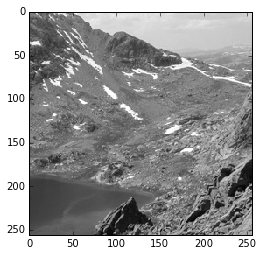

In [5]:
im = io.imread('../data/imgstat/alpine.png');
# im = io.imread('../data/imgstat/lake.jpg')
grayIm = color.rgb2gray(im)
plt.figure(); io.imshow(grayIm)

##Histogram of intensities

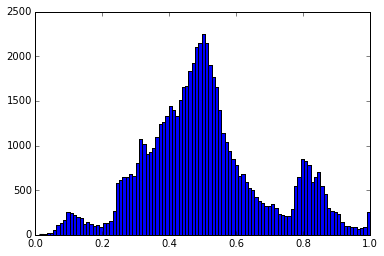

In [6]:
histCount, edge, tmp = plt.hist(grayIm.flatten(), bins=100)

##Histogram of spatial derivatives of intensity

Pick the radius of the filter (pixelradius), and the degree (nderivative) of the spatial derivative.

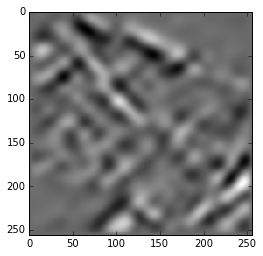

In [7]:
pixelRadius = 16; nderivative = 1;
fgrayIm = ndimage.gaussian_filter(grayIm, sigma = pixelRadius/2, order=(nderivative, nderivative))
io.imshow(fgrayIm)

##Plot the histogram and calculate its kurtosis

Kurtosis 3.01058750335
Kurtosis = 4.660904


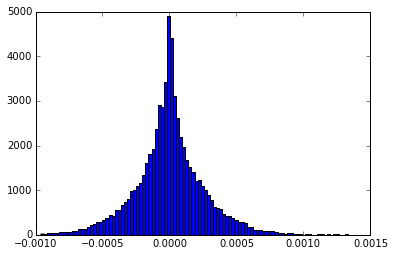

In [8]:
plt.hist(fgrayIm.flatten(), bins = 100);
print 'Kurtosis', stats.kurtosis(grayIm.flatten(), fisher=False)
print 'Kurtosis = %f' % stats.kurtosis(fgrayIm.flatten(), fisher=False)

## Exercise

Try increasing the order of the derivative

Kurtosis = 3.859692


<function __main__.manipulateGuassianOrder>

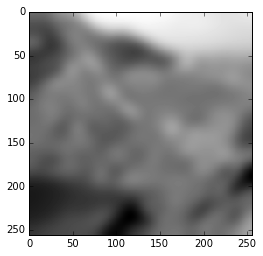

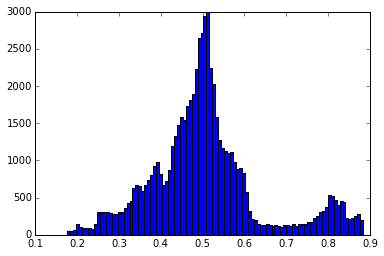

In [10]:
from IPython.html.widgets import interact
def manipulateGuassianOrder(order=0):
    pixelRadius = 16;
    fgrayIm = ndimage.gaussian_filter(grayIm, sigma = pixelRadius/2, order=(order, order))
    io.imshow(fgrayIm)
    plt.figure()
    plt.hist(fgrayIm.flatten(), bins = 100);
    print 'Kurtosis = %f' % stats.kurtosis(fgrayIm.flatten(), fisher=False)
interact(manipulateGuassianOrder, order= (0, 3))

##Second order statistics

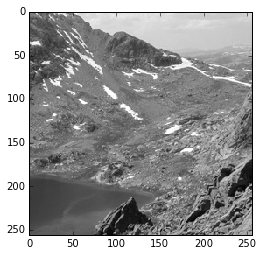

In [13]:
def LinearScale(vals, scaleRange=(0.0, 255.0)):
    # Linear scale data from original range to target range
    flat = vals.flatten()
    a = (scaleRange[1] - scaleRange[0]) / (flat.max() - flat.min())
    scaled = a * (vals - vals.min())
    return scaled

im = io.imread('../data/imgstat/alpine.png')
grayIm = color.rgb2gray(im)
img256 = LinearScale(grayIm, scaleRange=(0,255))
whitenIm = img256 - img256.mean()

io.imshow(whitenIm)

##Autocorrelation

Illustrates how nearby pixel intenstities tend to be correlated. Can you fit the autocorrelation with an exponential?

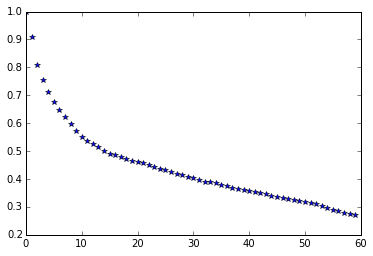

In [14]:
def HorizRotIm(im, offset): # Rotate image in horizontal direction
    rotIm = np.hstack((im[:,offset:], im[:, :offset]))
    return rotIm
    
im = whitenIm
mean0 =  (im * im).mean()
corr = [(im * HorizRotIm(im, offset)).mean() / mean0 for offset in range(60)]
plt.plot(corr, '*')

## Joint histogram of responses from two filters

###Set up kernels for the filters

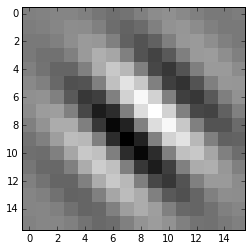

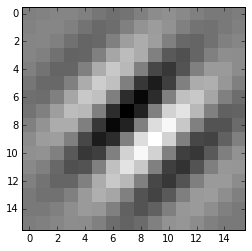

In [15]:
def GaborFilter(fx, fy, sigma, fsize, func):
    [x, y] = np.meshgrid(range(fsize), range(fsize))
    x = x - fsize/2
    y = y - fsize/2
    imFilter = np.exp((-x**2 -y**2) / (2 * sigma**2)) * func(2*math.pi * (fx * x + fy * y))
    return imFilter

def SinGabor(fx, fy, sigma, fsize):
    return GaborFilter(fx, fy, sigma, fsize, func=np.sin)
def CosGabor(fx, fy, sigma, fsize):
    return GaborFilter(fx, fy, sigma, fsize, func=np.cos)

filter1 = SinGabor(1.0/8, -1.0/8, 4.0, 16)
filter2 = SinGabor(1.0/8, 1.0/8, 4.0, 16)
plt.figure(); io.imshow(filter1)
plt.figure(); io.imshow(filter2)

###Convolution

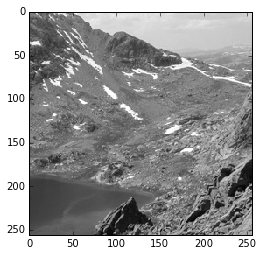

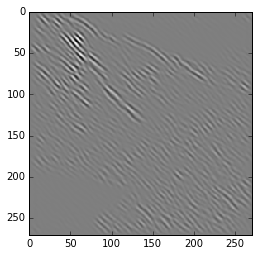

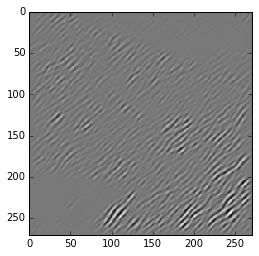

In [16]:
plt.figure(); io.imshow(grayIm)
fim1 = signal.convolve2d(whitenIm, filter1)
plt.figure(); io.imshow(fim1)
fim2 = signal.convolve2d(whitenIm, filter2)
plt.figure(); io.imshow(fim2)

##2D histogram

The above filters are centered at the same place, but orthogonal to each other. We can also shift the filtered outputs relative to each other with the variable offset below.

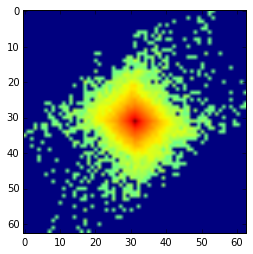

In [17]:
offset = 10; binSize = 4;
xedges = yedges = np.arange(0, 256, binSize)
fim1 = LinearScale(fim1, scaleRange=(0,255))
fim2 = LinearScale(fim2, scaleRange=(0,255))
fim2 = HorizRotIm(fim1, -offset);
H, xedges, yedges = np.histogram2d(fim1.flatten(), fim2.flatten(), bins=(xedges, yedges))
eps = 0.0001
plt.imshow(np.log(H+eps))

##Bow-tie: Normalize the columns to represent conditional probabilities - i.e. elements in a column sum to one

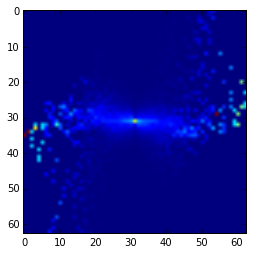

In [18]:
P = H / np.tile(H.sum(axis=1) + eps, (H.shape[0],1))
plt.imshow(P)

See: Schwartz, O., & Simoncelli, E. P. (2001). Natural signal statistics and sensory gain control. Nature Neuroscience, 4(8), 819–825. doi:10.1038/90526